#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

In [1]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [2]:
file = '../data/singlecoil_train/file1000003.h5'
hf = h5py.File(file)

In [3]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'norm': 0.34417799215708206, 'max': 0.0011196501434476845, 'patient_id': '677ac6bd798aca92edebad9da68aa744609053cc748717fb327d5ac18ed6b328', 'acquisition': 'CORPD_FBK'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [4]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(45, 640, 368)


In [5]:
type(volume_kspace)

numpy.ndarray

In [6]:
slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume

Let's see what the absolute value of k-space looks like:

In [7]:
# def show_slices(data, slice_nums, cmap=None):
#     fig = plt.figure()
#     for i, num in enumerate(slice_nums):
#         plt.subplot(1, len(slice_nums), i + 1)
#         plt.imshow(data[num], cmap=cmap)

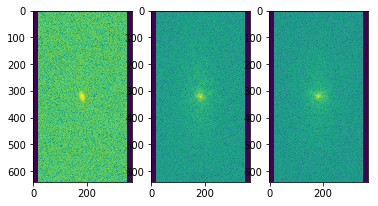

In [15]:
def show_singlecoil_slices(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

show_singlecoil_slices(np.log(np.abs(volume_kspace) + 1e-9), [0,5,10])

In [20]:
np.log(np.abs(volume_kspace[0]) + 1e-9)

array([[-20.723267, -20.723267, -20.723267, ..., -20.723267, -20.723267,
        -20.723267],
       [-20.723267, -20.723267, -20.723267, ..., -20.723267, -20.723267,
        -20.723267],
       [-20.723267, -20.723267, -20.723267, ..., -20.723267, -20.723267,
        -20.723267],
       ...,
       [-20.723267, -20.723267, -20.723267, ..., -20.723267, -20.723267,
        -20.723267],
       [-20.723267, -20.723267, -20.723267, ..., -20.723267, -20.723267,
        -20.723267],
       [-20.723267, -20.723267, -20.723267, ..., -20.723267, -20.723267,
        -20.723267]], dtype=float32)

TypeError: Invalid dimensions for image data

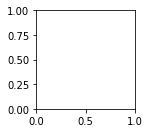

In [8]:
# show_slices(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10])  # This shows slices 0, 5 and 10

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [21]:
from data import transforms as T

In [26]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = T.ifft2(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = T.complex_abs(slice_image)   # Compute absolute value to get a real image

volume_kspace2 = T.to_tensor(volume_kspace)
volume_image = T.ifft2(volume_kspace2)
volume_image_abs = T.complex_abs(volume_image)

In [28]:
print(slice_kspace2.shape)
print(slice_kspace2.dtype)
print(slice_image.shape)
print(slice_image.dtype)
print(slice_image_abs.shape)
print(slice_image_abs.dtype)

print(volume_kspace2.shape)
print(volume_kspace2.dtype)
print(volume_image.shape)
print(volume_image.dtype)
print(volume_image_abs.shape)
print(volume_image_abs.dtype)

torch.Size([640, 368, 2])
torch.float32
torch.Size([640, 368, 2])
torch.float32
torch.Size([640, 368])
torch.float32
torch.Size([45, 640, 368, 2])
torch.float32
torch.Size([45, 640, 368, 2])
torch.float32
torch.Size([45, 640, 368])
torch.float32


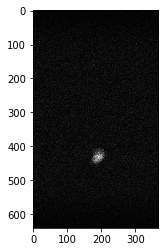

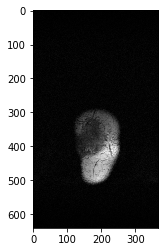

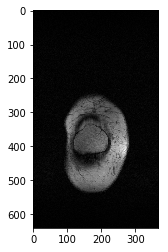

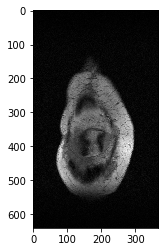

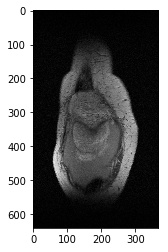

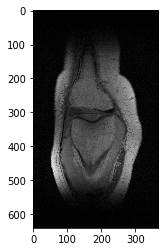

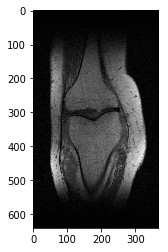

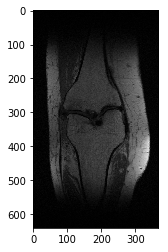

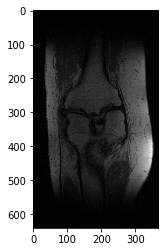

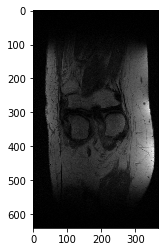

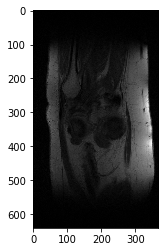

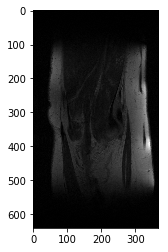

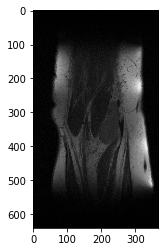

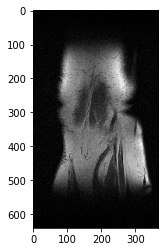

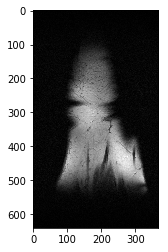

In [39]:
# show_singlecoil_slices(volume_image_abs, [0, 5, 10], cmap='gray')
for i in range(0, len(volume_image_abs), 3):
    show_singlecoil_slices(volume_image_abs, [i], cmap='gray')
# show_singlecoil_slices(volume_image_abs, list(range(len(volume_image_abs))), cmap='gray')

As we can see, each slice in a multi-coil MRI scan focusses on a different region of the image. These slices can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [30]:
# slice_image_rss = T.root_sum_of_squares(slice_image_abs, dim=0)
volume_image_rss = T.root_sum_of_squares(volume_image_abs, dim=0)

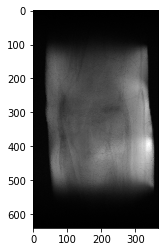

In [31]:
# plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')
plt.imshow(np.abs(volume_image_rss.numpy()), cmap='gray')

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [32]:
from common.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [34]:
# masked_kspace, mask = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space
masked_kspace, mask = T.apply_mask(volume_kspace2, mask_func)   # Apply the mask to k-space

Let's see what the subsampled image looks like:

In [35]:
# sampled_image = T.ifft2(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
# sampled_image_abs = T.complex_abs(sampled_image)   # Compute absolute value to get a real image
# sampled_image_rss = T.root_sum_of_squares(sampled_image_abs, dim=0)

sampled_image = T.ifft2(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = T.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = T.root_sum_of_squares(sampled_image_abs, dim=0)

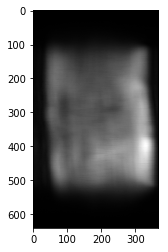

In [36]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')